In this lab, a [Shazam](http://bit.ly/1fvTDIQ)-similar system is implemented. An acoustic fingerprint of a song is generated by hashing the frequency and time information in the spectrogram. A fingerprint of a snippet is later generated and searched through the database of hashes. A high number of matches is found if the snippet comes from the corresponding song. 

# Shazam: Audio Recognition System

As usual, we set the pylab inline option and import necessary modules. 

In [4]:
%pylab inline
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter # find the peaks in the spectrogram
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure)
from pydub import AudioSegment #read wav file.
import hashlib # to generate hash from the frequency and time information

Populating the interactive namespace from numpy and matplotlib


/Users/yuhantang/anaconda/lib/python2.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


We define a function called readAudioFile to read the **wav** file. *limit* is the number of seconds from the beginning of the song we would like to read. If *limit* is None, readAudioFile returns the data for the whole song. 

In [5]:
def readAudioFile(filename, limit= None):
    audiofile = AudioSegment.from_wav(filename)
    if limit:
        audiofile = audiofile[:limit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels])        
    return channels, audiofile.frame_rate, audiofile

We will implement the Shazam [paper](http://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf). We will refer to figures in this paper. 
Next we define two functions:

1. **get_2D_peaks**: Find the peaks in the spectrogram. Refer to figure 1B of the paper. The set of peaks of the spectrogram is also called the constellation map. 
2. **generate_hashes**: Generate the hashes from the constellation map. See figure 1C and 1D. The struture of the hashes is [f1:f2:delta_t]:t1. Then we call the hashlib function sha1 to generate a single number for our hash. For this demo, we keep the first 25 values of the hash. **note:** 
Increase in number of hases indicates a increase in the accuracy in finding the song

In [6]:
def get_2D_peaks(arr2D, plot,amp_min = 10):
    struct   = generate_binary_structure(2,1)
    neighborhood  = iterate_structure(struct, 20)
    detected_peaks = maximum_filter(arr2D, footprint  = neighborhood) == arr2D
    amps = arr2D[detected_peaks]
    j,i  = np.where(detected_peaks) 
    amps = amps.flatten()
    peaks = zip(j,i, amps)
    peaks_filtered = [x for x in peaks if x[2]>amp_min]
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(frequency_idx, time_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.axis('tight')
    return zip(frequency_idx, time_idx)
def generate_hashes(peaks, fan_value = 10, len_hash = 25):
    fingerprinted = set()  
    for i in range(len(peaks)):
        for j in range(fan_value):
            if (i + j) < len(peaks) and not (i, i + j) in fingerprinted:
                freq1 = peaks[i][1]
                freq2 = peaks[i + j][1]
                t1 = peaks[i][0]
                t2 = peaks[i + j][0]
                t_delta = t2 - t1
                if t_delta >= 0:
                    h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta))) 
                    yield (h.hexdigest()[0:len_hash], t1)
                fingerprinted.add((i, i + j))             

The following function **fingerpint** returns the hashes of an audio file. 

In [7]:
def fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot):
    arr2D = mlab.specgram(samples, NFFT = wsize, Fs = Fs, window = mlab.window_hanning, noverlap = int(wsize * wratio))[0];
    arr2D = 10 * np.log10(arr2D+0.001)
    arr2D[arr2D == -np.inf] = 0
    local_maxima = get_2D_peaks(arr2D, plot, amp_min = amp_min)
    return generate_hashes(local_maxima, fan_value = fan_value, len_hash = 25)

Now we are ready to extract and save the fingerprints. First we read the audio file from the wav folder. You can input your own wav file there. Define sampling rate, window size, overlap ratio between consecutive frames. [pydub](https://github.com/jiaaro/pydub/) can read mp3 file, but you need to configure ffmpeg. You might do that on your own computer.

In [ ]:
channels, framerate,data = readAudioFile('wav/JonBoden.wav')
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = False
for samples in channels:
    hashes = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)

For easy visualization and explanation, we will convert our hashes into a dictionary of the form: **dict[hash] = t1**. Dictionaries consist of pairs of **keys** and their corresponding **values**. We use the hashes as keys and the time of the hash as value. Since different segments from the audio file can produce the same hash, one key might correspond to multiple values (multiple starting times t1). We use the *defaultdict* data structure to accomodate multiple-valued-single-key entries. 

In [19]:
from collections import defaultdict
def hashesToDict(hashesExcerpt):
    dataExcerpt  = []
    for i in hashesExcerpt:
        dataExcerpt.append(i)
    dictExcerpt = defaultdict(list)
    for hashString, t1 in dataExcerpt:
        dictExcerpt[hashString].append(t1)
    return dictExcerpt

Now we convert the hashes to a dictionary called **dictOriginal**. **dictOriginal** contains all the hashes of the *'JonBoden.wav'* song. The key is the hash and the value is the time. See figure 1D in the paper.

In [20]:
dictOriginal = hashesToDict(hashes)

To implement searching, we could implement [mySQL](http://mysql-python.sourceforge.net/) databases. This provides a systematic approach to store, retrieve and search for hashes. mySQL requires a mySQL server, which adds a level of complexity to this project. For now, we only save the fingperprints into a file and later retrieve them if we need. 

In [21]:
import pickle
fileHandle  = open("JonBoden.fp","wb") #wb: write binary
pickle.dump(dictOriginal, fileHandle)

### Testing the System

Now we load the fingerprinted file back and store it as **dictOriginal**. You can fingerprint as many files as you want, then read all of them here. 

In [22]:
fileHandle = open("JonBoden.fp","rb")
dictOriginal = pickle.load(fileHandle)
fileHandle.close()

**Exercise 1**. Write a function called readAudioFileExcerpt with three inputs. See the readAudioFile function above for guidance. The first input is the filename. The other two inputs are lowLimit and highLimit, which is used to read the audio file from lowLimit to highLimt seconds.

In [23]:
def readAudioFileExcerpt(filename, lowLimit, highLimit):
    audiofile = AudioSegment.from_wav(filename)
    if highLimit:
        audiofile = audiofile[:highLimit*1000]
    if lowLimit:
        audiofile = audiofile[lowLimit*1000:]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in xrange(audiofile.channels):
        channels.append(data[chn::audiofile.channels])
    return channels, audiofile.frame_rate, audiofile


**Excercise 2**. Use your function to read the excerpt from the JonBoden.wav and generate the hashes from this snippet. Name the hahses **hashesExcerpt1**. Also, we've set the plot parameter to True to visualize the peaks of the spectrogram. What parameters in the **fingerprint** function affect the number of peaks?

The wratio, amp_min, wsize, Fs can affect he number of peaks

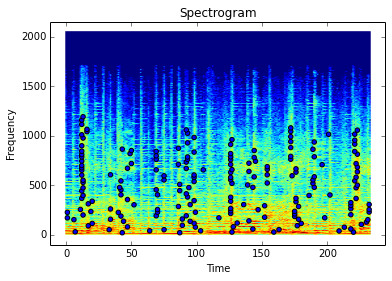

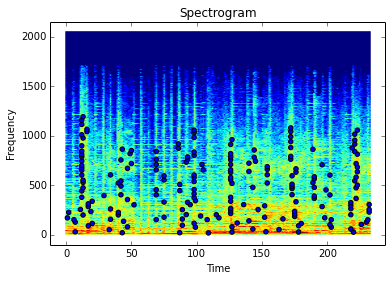

In [24]:
# write your code here.
# read in the audio snippit from 40s to 50s
channelsExcerpt1, framerate, data = readAudioFileExcerpt('wav/JonBoden.wav',40,50)
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = True
# but now we want to visualize the peak (pass this as a parameter to get_2D_peaks)
# call the fingerprint function to generate the hashes. 
for samples in channelsExcerpt1:
    hashesExcerpt1 = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)

Now we convert the **hashesExcerpt1** to a dictionary. We can call the **hashesToDict** function defined earlier.

In [25]:
dictExcerpt1 = hashesToDict(hashesExcerpt1)

**Excercise 3**. Write a function to match the fingerprint of the excerpt to the original song. Return count and delta_k. Count is the number of matching hashes. delta_k is a list of offsets of the database song time and the snippet song time. See section 2.3 of the paper. Read also [this document](http://www.tutorialspoint.com/python/python_dictionary.htm) on how to manipulate the dictionary.

In [26]:
def match_fingerprint(dictExcerpt,dictOriginal):
    count  = 0
    delta_k = []
    for i in dictExcerpt.keys():
        if i in dictOriginal.keys():
            count+=1
            for j in dictExcerpt[i]:
                for k in dictOriginal[i]:
                    delta_k.append(k-j)
    return count, delta_k

Let's count how many matches are found and plot the histogram of the offsets.

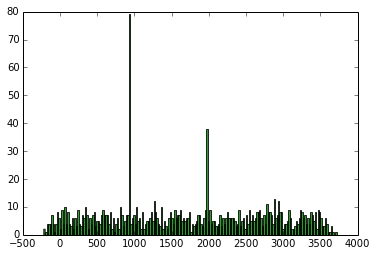

In [27]:
count1, delta_k1 = match_fingerprint(dictExcerpt1, dictOriginal)
if delta_k1:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 200
    ax.hist(delta_k1,numBins,color='green',alpha=0.8)

**Exercise 4**. Now load the second file, count the number of matches, and plot the histogram of the offsets.

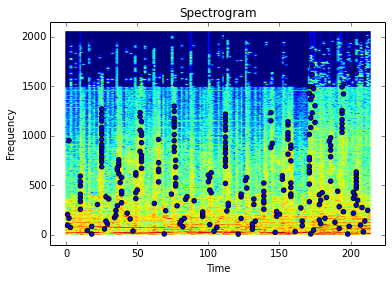

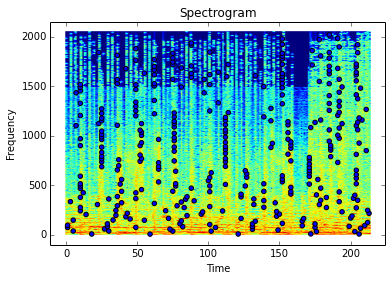

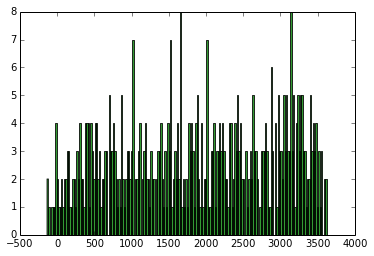

In [28]:
channelsExcerpt2, framerate, data = readAudioFileExcerpt('wav/BreakingtheHabit.wav',40,50)
Fs = 44100 # sampling freq
wsize  = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = True
# but now we want to visualize the peak (pass this as a parameter to get_2D_peaks)
# call the fingerprint function to generate the hashes. 
for samples in channelsExcerpt2:
    hashesExcerpt2 = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)

dictExcerpt2 = hashesToDict(hashesExcerpt2)
count2, delta_k2 = match_fingerprint(dictExcerpt2, dictOriginal)
if delta_k2:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 200
    ax.hist(delta_k2,numBins,color='green',alpha=0.8)

**Exercise 5**. Based on the number of matches (consider how many possible matches there are) and histogram of offsets, justify that your code produces a desirable result. 

The first piece has a better performance in matching. The 2nd piece is not as good as the first one, but still resonable

**Exercise 6.** Now to test the system. Use the provided dataset of 1886 songs to test the accuracy of the Shazam system. You will need to generate a dictionary for each song (follow the steps above in the lab) and store it. Use all of the songs in the query dataset to test for recognition accuracy. These songs have been played back and re-recorded to simulate an actual use-case of Shazam. (Give the songs a listen to compare and compare the originals to the queries.) For each query song, find and print its best match in the dataset of songs. The best match should be the song for which the peak on the histogram of deltas is highest. Also print the overall accuracy for the test set of queries.

Some starter code has been provided to generate the list of file names in each of the directories and to extract the name of the song from the file name.

In [29]:
import glob
import os

songsdir = 'songs/'
querydir = 'query_songs/'
fingerprintdir = 'fingerprints/'

# extract the file names in each of the folders
songs = glob.glob(songsdir + '*.wav')
songs_query = glob.glob(querydir + '*.wav')

if not os.path.exists(fingerprintdir):
    os.makedirs(fingerprintdir)
    

In [32]:

Fs = 44100 # sampling freq
wsize = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = False
for song in songs:
    song_name = os.path.split(os.path.splitext(song)[0])[1]  # a string storing the name of the song
    channels, framerate, data = readAudioFile(song)
    for samples in channels:
        hashes = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot)
    dictOriginal = hashesToDict(hashes)
    
    fileHandle  = open(fingerprintdir + song_name + ".fp", "wb") #wb: write binary
    pickle.dump(dictOriginal, fileHandle)
    

In [65]:
import difflib
import types
Fs = 44100 # sampling freq
wsize = 4096 # window size
wratio = 0.5 # overlap ratio
fan_value = 10 #number of target points in the frequency domain to pair with the anchor point
amp_min = 25 # minimum amplitude of the peak.
plot = False
numBins = 200
count_correct = 0
delta_k3_max = 0
total=0
for query in songs_query:
    query_name = os.path.split(os.path.splitext(query)[0])[1]  # a string storing the name of the query song
    
    channelsExcerpt3, framerate, data = readAudioFile(query)
    for samples in channelsExcerpt3:
        hashesExcerpt3 = fingerprint(samples, Fs, wsize, wratio, fan_value, amp_min, plot) 
    dictExcerpt3 = hashesToDict(hashesExcerpt3)
    fingerprints = glob.glob(fingerprintdir + '*.fp')
    match_dictionary = types.DictType.__new__(types.DictType, (), {})
    for fp in fingerprints:
        f_name = os.path.split(os.path.splitext(fp)[0])[1]
        fileHandle = open(fp,"rb")
        dictOriginal = pickle.load(fileHandle)    
        count, delta_k3 = match_fingerprint(dictExcerpt3,dictOriginal)
        
        if delta_k3:
            hist,bin_edges = np.histogram(delta_k3, numBins)
            #print hist
            delta_k3_max = np.amax(hist)
            match_dictionary[f_name]=delta_k3_max
    match_value=max(match_dictionary.values())
    for name in match_dictionary.iterkeys():
        if match_value == match_dictionary[name]:
            found_name = name
    s = difflib.SequenceMatcher(None, query_name, found_name)
    if difflib.get_close_matches(query_name,found_name)!=[]:
        count_correct+=1
    elif s.real_quick_ratio()>=0.9:
        count_correct+=1
    total+=1
    print "query = %s, song = %s,"%(query_name,found_name)
print "\naccuracy = %f%s" % (count_correct/float(total)*100,"percent")

    # your code to compare the fingerprint of the query against the fingerprint database
    
    # print the name of the query song and its best match for each query
    

query = 1nothing_walk_away, song = 1nothing-walk_away,
query = 4TH_PLANE_JAIANT-Let_It_Breate, song = 4TH_PLANE_JAIANT-Let_It_Breathe,
query = 5_Star_Day-Selfish_Eyes, song = 5_Star_Day-Selfish_Eyes,
query = aKido-Playtime, song = aKido-Playtime,
query = Alex_Niedt-But_I_Love_You___, song = Alex_Niedt-But_I_Love_You___,
query = Alms_For_Shanti-Everlife___remixed, song = Alms_For_Shanti-Everlife___remixed,
query = Andre_Donawa-A_Dolphin_s_Dream, song = Andre_Donawa-A_Dolphin_s_Dream,
query = Animism-Only_What_you_Make_It, song = Animism-Only_What_you_Make_It,
query = ATMA-Immanuel_s_Labor, song = ATMA-Immanuel_s_Labor,
query = autoReverse-Home, song = autoReverse-Home,
query = Azuris_Aurum-Terrene_Dream, song = Azuris_Aurum-Terrene_Dream,
query = BB_CHUNG_KING_AND_THE_BUDDAHEADS-when_the_blues_catch_up_with_you, song = BB_CHUNG_KING_AND_THE_BUDDAHEADS-when_the_blues_catch_up_with_you,
query = bitterbeat-serpentineliar, song = bitterbeat-serpentineliar,
query = Blackwell_a_k_a_Da_ILL_Mal

**Extra Credit.** There is one component not yet implemented, which is reading the audio snippet from the microphone. This is not mandatory, but you can try it yourself if you have time. It is suggested to use [pyaudio](http://people.csail.mit.edu/hubert/pyaudio/). 

In [63]:
s = difflib.SequenceMatcher(None, query_name+'asdf', found_name)
print s.ratio()

0.960784313725
